In [23]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from copy import deepcopy
from astropy.convolution import convolve

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import psf

# Generate images with various PSFs

In [24]:
lens = SampleStrongLens()

num_pix = 45
side = 4.95
band = 'F184'

## Grab default substructure

In [25]:
# add CDM subhalos; NB same subhalo population for all
# lens.add_subhalos(util.unpickle(os.path.join(pickle_dir, 'cdm_subhalos_for_sample')))

## generate arrays

In [26]:
lens_1 = deepcopy(lens)
lens_3 = deepcopy(lens)
lens_5 = deepcopy(lens)
lens_7 = deepcopy(lens)

array_1 = lens_1.get_array(band=band, num_pix=num_pix, side=side)
array_3 = lens_3.get_array(band=band, num_pix=num_pix * 3, side=side)
array_5 = lens_5.get_array(band=band, num_pix=num_pix * 5, side=side)
array_7 = lens_7.get_array(band=band, num_pix=num_pix * 7, side=side)

## Band

In [27]:
detector = 1
detector_position = (2048, 2048)

kernel_f106 = psf.get_psf_kernel('F106', detector, detector_position, oversample=5, fov_arcsec=side)
kernel_f129 = psf.get_psf_kernel('F129', detector, detector_position, oversample=5, fov_arcsec=side)
kernel_f158 = psf.get_psf_kernel('F158', detector, detector_position, oversample=5, fov_arcsec=side)
kernel_f184 = psf.get_psf_kernel('F184', detector, detector_position, oversample=5, fov_arcsec=side)

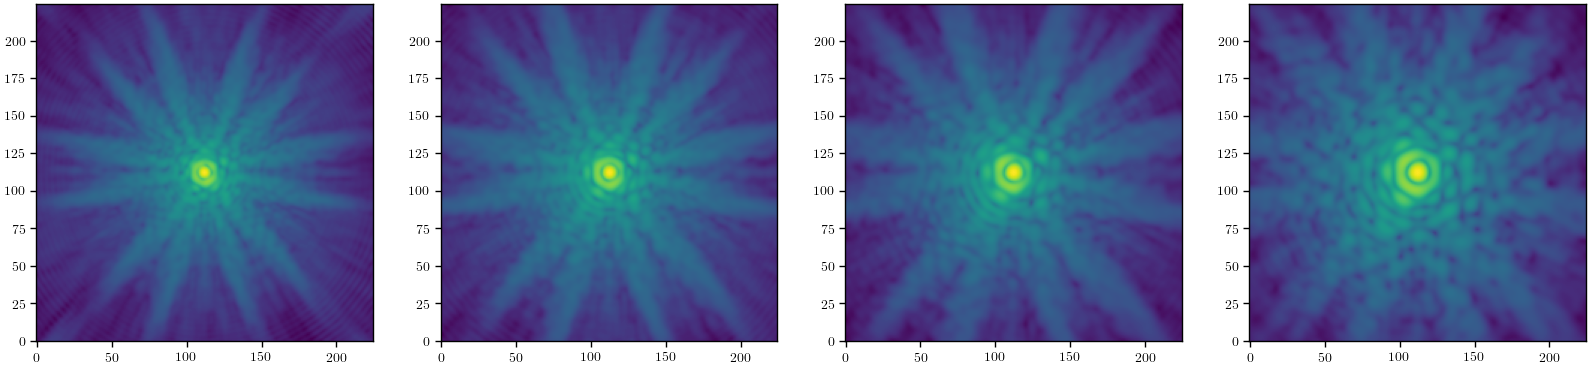

In [28]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(np.log10(kernel_f106))
ax[1].imshow(np.log10(kernel_f129))
ax[2].imshow(np.log10(kernel_f158))
ax[3].imshow(np.log10(kernel_f184))
# for a in ax:
#     a.axis('off')
plt.show()

In [29]:
band_f106 = convolve(array_5, kernel_f106)
band_f129 = convolve(array_5, kernel_f129)
band_f158 = convolve(array_5, kernel_f158)
band_f184 = convolve(array_5, kernel_f184)

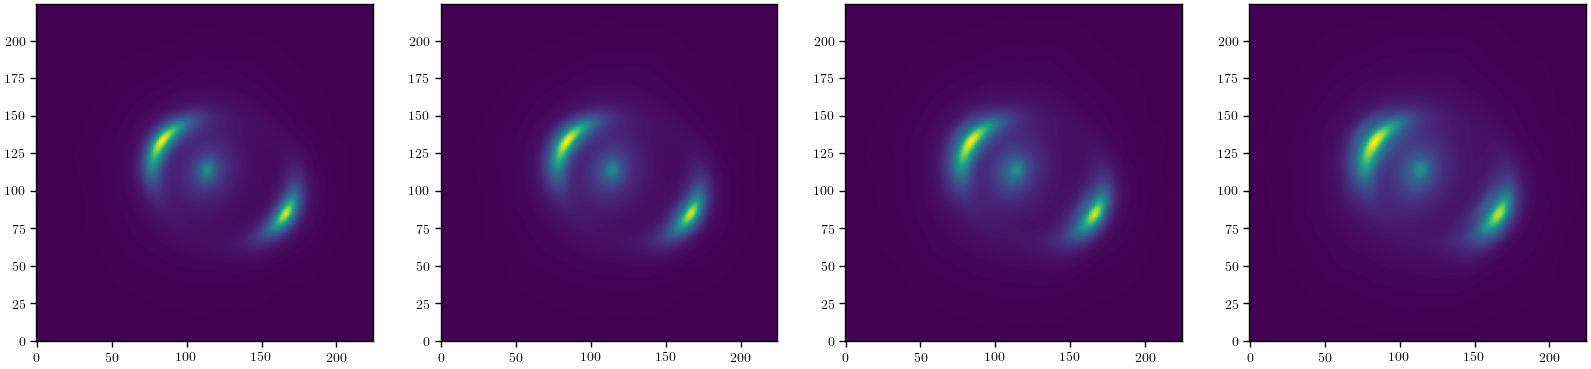

In [36]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(band_f106)
ax[1].imshow(band_f129)
ax[2].imshow(band_f158)
ax[3].imshow(band_f184)
# for a in ax:
#     a.axis('off')
plt.show()

## Oversampling

In [31]:
detector = 1
detector_position = (2048, 2048)

kernel_1 = psf.get_psf_kernel(band, detector, detector_position, oversample=1, fov_arcsec=side)
kernel_3 = psf.get_psf_kernel(band, detector, detector_position, oversample=3, fov_arcsec=side)
kernel_5 = psf.get_psf_kernel(band, detector, detector_position, oversample=5, fov_arcsec=side)
kernel_7 = psf.get_psf_kernel(band, detector, detector_position, oversample=7, fov_arcsec=side)

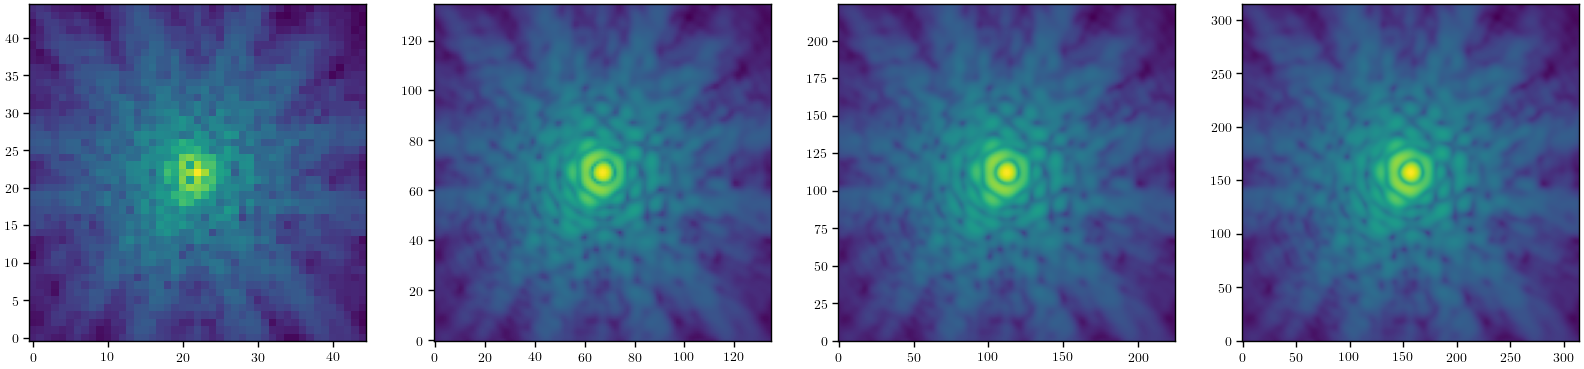

In [32]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(np.log10(kernel_1))
ax[1].imshow(np.log10(kernel_3))
ax[2].imshow(np.log10(kernel_5))
ax[3].imshow(np.log10(kernel_7))
# for a in ax:
#     a.axis('off')
plt.show()

In [39]:
oversample_1 = convolve(array_1, kernel_1)
oversample_3 = convolve(array_3, kernel_3)
oversample_5 = convolve(array_5, kernel_5)
oversample_7 = convolve(array_7, kernel_7)

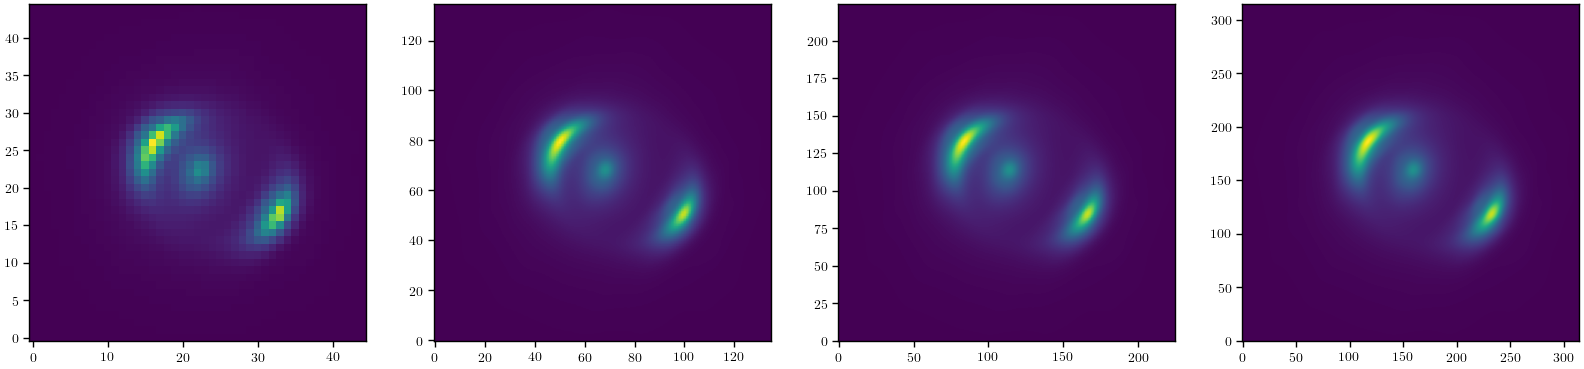

In [40]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(oversample_1)
ax[1].imshow(oversample_3)
ax[2].imshow(oversample_5)
ax[3].imshow(oversample_7)
# for a in ax:
#     a.axis('off')
plt.show()

# Plot

In [13]:
no_psf = np.load(os.path.join(array_dir, 'sample_skypy_lens', 'no_psf.npy'))
gaussian_psf = np.load(os.path.join(array_dir, 'sample_skypy_lens', 'gaussian_psf.npy'))
webbpsf = np.load(os.path.join(array_dir, 'sample_skypy_lens', 'webbpsf.npy'))

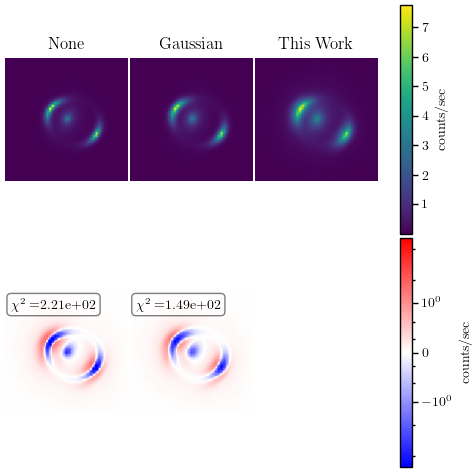

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(6, 6), gridspec_kw={'hspace': 0.02, 'wspace': 0.02})  # 

array_list = [no_psf, gaussian_psf, webbpsf]
title_list = ['None', 'Gaussian', 'This Work']

for i, array in enumerate(array_list):
    axis_1 = ax[0][i].imshow((array), cmap='viridis')
    ax[0][i].set_title(title_list[i])
    ax[0][i].set_axis_off()

cbar = fig.colorbar(axis_1, ax=ax[0])
cbar.set_label('counts/sec', rotation=90)

array_list = [webbpsf - no_psf, webbpsf - gaussian_psf]  # , gaussian_psf - no_psf
title_list = ['WebbPSF - No PSF', 'WebbPSF - Gaussian PSF']  # , 'Gaussian PSF - No PSF'

# compute mean chi square
chi_square_list = []
chi_square_list.append(stats.chi_square(no_psf, webbpsf))
chi_square_list.append(stats.chi_square(gaussian_psf, webbpsf))
# chi_square_list.append(stats.chi_square(gaussian_psf, no_psf))
chi_square_list = ['$\chi^2 = $' + '{:.2e}'.format(i) for i in chi_square_list]

norm = plot_util.get_norm(array_list, linear_width=0.5)
props = dict(boxstyle='round', facecolor='w', alpha=0.5)

ax[1][0].imshow(webbpsf - no_psf, cmap='bwr', norm=norm)
axis_2 = ax[1][1].imshow(webbpsf - gaussian_psf, cmap='bwr', norm=norm)
ax[1][0].text(0.05, 0.95, chi_square_list[0], transform=ax[1][0].transAxes,
            verticalalignment='top', bbox=props)
ax[1][1].text(0.05, 0.95, chi_square_list[1], transform=ax[1][1].transAxes,
            verticalalignment='top', bbox=props)

for each in ax[1]:
    each.set_axis_off()

cbar_residuals = fig.colorbar(axis_2, ax=ax[1], ticks=[-1, 0, 1])
cbar_residuals.set_label('counts/sec', rotation=90)

plt.savefig(os.path.join(figure_dir, 'psf_compare.png'))
plt.show()